In [8]:
import numpy as np
import pandas as pd
np.random.seed(7)

# my own libraries
import prepare_data
import inspect_results as inspect

# for baselines
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# for the deep learning model
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, losses, activations
from tensorflow.keras.callbacks import EarlyStopping

# for visualization
import matplotlib.pyplot as plt

# Load & Prepare Data

**This notebook is only for parameter tunning!!**

Succesfully loaded PHM08 data from train.txt
Succesfully calculated the CTFs (Cycles to Failure).
Succesfully calculated the RULs (Remaining Useful Lives).
Succesfully calculated the Heath States.


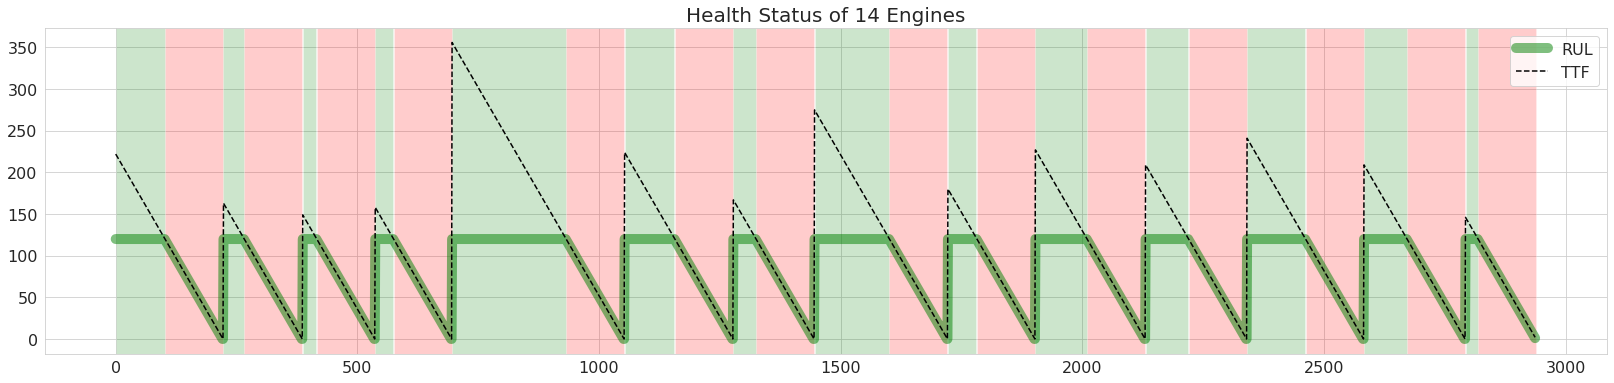

In [9]:
cmapss = prepare_data.CMAPSS()

"""dev model should be fisrt true, 
and only if we decide to start labeling 
the test set provided by NASA we should set it to FALSE"""
dev_mode = True 

path = "../../Datasets/PHM08_Challenge_Data/train.txt"

dev_data = cmapss.load_data(path)
dev_data = cmapss.cluster_operational_settings(dev_data, dev_mode)
dev_data = cmapss.calculate_TTF(dev_data)
dev_data = cmapss.calculate_continues_healthstate(dev_data)
dev_data = cmapss.calculate_descrete_healthstate(dev_data)
cmapss.visualize_healthstatus(dev_data, 14) # engines to visualize

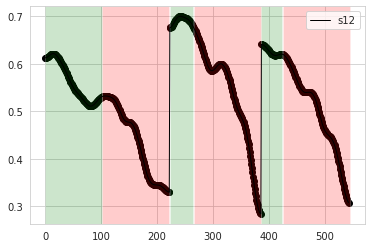

In [10]:
dev_data = cmapss.get_univariate_cmapss(dev_data, "s12")
x_train, x_test = cmapss.train_test_split(dev_data)
x_train = cmapss.minmax_scale(x_train)
x_train = cmapss.denoise_sensors(x_train)
cmapss.visualize_denoised_sensors(x_train, 3)

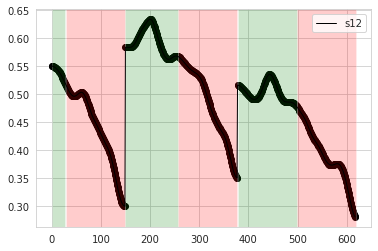

In [11]:
x_test = cmapss.minmax_scale(x_test)
x_test = cmapss.denoise_sensors(x_test)
cmapss.visualize_denoised_sensors(x_test, 3)

In [12]:
w_size=20
x_train, y_train = cmapss.window_data(x_train, w_size, w_size//2)
x_test, y_test = cmapss.window_data(x_test, w_size, w_size//2)

print("Trainset shape: data={}\nTestset shape: data={}".format(
      x_train.shape, x_test.shape))

Trainset shape: data=(3136, 20)
Testset shape: data=(1332, 20)


# Deep Neural Networks

In [20]:
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, losses, activations
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
input_shape = (x_train.shape[1], 1)

x_train = np.asarray(x_train, dtype="float")
x_test = np.asarray(x_test, dtype="float")

y_train = np.asarray(y_train, dtype="float")
y_test = np.asarray(y_test, dtype="float")

## Hyper Parameter Tuning

In [43]:
!{sys.executable} -m pip install talos
# source: https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53

     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 51 kB 648 kB/s 
     |████████████████████████████████| 5.4 MB 13.0 MB/s 
     |████████████████████████████████| 9.8 MB 29.2 MB/s 
     |████████████████████████████████| 2.6 MB 53.9 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41609 sha256=cb20e45716cca539822ccea451c155ec2136fce97650534bd6a913ff1677d58d
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-py3-none-any.whl size=3603 sha256=bc6297cd0bb365f028d939d81611c6c77e088ec47829ef1b2a95175c071cdfa0
  Stored in directory: /root/.cache/pip/wheels/1c/b4/c8/d1533d85f7fc617e3201c3f41b79fe49ae9284c8fc4a5bd4b2
Successfully built chances kerasplotlib
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uni

In [44]:
import talos as ta

In [55]:
def cmapss_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(LSTM(params['neurons'],
                  activation=params['activation'], 
                  #return_sequences=True,
                  input_shape=input_shape))
    model.add(Dropout(params['dropout']))

#     lstm.add(LSTM(params['neurons'], activation=params['activation']))  
#     lstm.add(Dropout(params['dropout']))

    model.add(Dense(1, activation="sigmoid",
                    kernel_initializer='normal'))
    
    model.compile(loss=params['losses'],
                  # here we add a regulizer normalization function from Talos
                  optimizer=params['optimizer'](lr=params['lr']),
                  metrics=['acc'])
    
    history = model.fit(x_train[:, :, np.newaxis], y_train, 
                        validation_split=0.30,
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)

    return history, model

In [63]:
p = {'lr': [0.01, 0.001],
     'neurons':[5, 15],
     'batch_size': [16, 32],
     'epochs': [100],
     'dropout': [0.1, 0.2],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'shape':['brick','long_funnel'],
     'optimizer': [optimizers.SGD, optimizers.Adam, optimizers.RMSprop],
     'losses': [losses.binary_crossentropy],
     'activation':[activations.tanh, activations.relu],
     'last_activation': [activations.sigmoid]}

In [64]:
t = ta.Scan(x=x_train,
            y=y_train,
            model=cmapss_model,
            params=p,
            experiment_name='parameter_tuner_1')


100%|██████████| 192/192 [2:45:41<00:00, 51.78s/it]


In [70]:
analyze_object = ta.Analyze(t)

analyze_object.data

,start,end,duration,round_epochs,loss,acc,val_loss,val_acc,activation,batch_size,dropout,emb_output_dims,epochs,last_activation,losses,lr,neurons,optimizer,shape,weight_regulizer
0,12/14/21-194102,12/14/21-194225,83.758072,100,0.497301,0.718099,0.490056,0.699545,<function tanh at 0x7f0a1a5a0170>,16,0.1,None,100,<function sigmoid at 0x7f0a1a5a0320>,<function binary_crossentropy at 0x7f0a1a8324d0>,0.010,5,<class 'keras.optimizer_v2.gradient_descent.SGD'>,brick,None
1,12/14/21-194226,12/14/21-194329,63.671535,100,0.481261,0.733724,0.485635,0.714719,<function tanh at 0x7f0a1a5a0170>,16,0.1,None,100,<function sigmoid at 0x7f0a1a5a0320>,<function binary_crossentropy at 0x7f0a1a8324d0>,0.010,5,<class 'keras.optimizer_v2.gradient_descent.SGD'>,long_funnel,None
2,12/14/21-194330,12/14/21-194436,66.368110,100,0.406498,0.798828,0.421682,0.781487,<function tanh at 0x7f0a1a5a0170>,16,0.1,None,100,<function sigmoid at 0x7f0a1a5a0320>,<function binary_crossentropy at 0x7f0a1a8324d0>,0.010,5,<class 'keras.optimizer_v2.adam.Adam'>,brick,None
3,12/14/21-194436,12/14/21-194542,65.961260,100,0.412986,0.794922,0.414430,0.778452,<function tanh at 0x7f0a1a5a0170>,16,0.1,None,100,<function sigmoid at 0x7f0a1a5a0320>,<function binary_crossentropy at 0x7f0a1a8324d0>,0.010,5,<class 'keras.optimizer_v2.adam.Adam'>,long_funnel,None
4,12/14/21-194543,12/14/21-194648,64.894298,100,0.427557,0.774089,0.421047,0.775417,<function tanh at 0x7f0a1a5a0170>,16,0.1,None,100,<function sigmoid at 0x7f0a1a5a0320>,<function binary_crossentropy at 0x7f0a1a8324d0>,0.010,5,<class 'keras.optimizer_v2.rmsprop.RMSprop'>,brick,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,12/14/21-222345,12/14/21-222420,34.676722,100,0.679004,0.585286,0.673741,0.608498,<function relu at 0x7f0a1a59cdd0>,32,0.2,None,100,<function sigmoid at 0x7f0a1a5a0320>,<function binary_crossentropy at 0x7f0a1a8324d0>,0.001,15,<class 'keras.optimizer_v2.gradient_descent.SGD'>,long_funnel,None
188,12/14/21-222420,12/14/21-222455,35.068541,100,0.474001,0.737630,0.490341,0.699545,<function relu at 0x7f0a1a59cdd0>,32,0.2,None,100,<function sigmoid at 0x7f0a1a5a0320>,<function binary_crossentropy at 0x7f0a1a8324d0>,0.001,15,<class 'keras.optimizer_v2.adam.Adam'>,brick,None
189,12/14/21-222456,12/14/21-222531,35.278142,100,0.464556,0.742839,0.468463,0.726859,<function relu at 0x7f0a1a59cdd0>,32,0.2,None,100,<function sigmoid at 0x7f0a1a5a0320>,<function binary_crossentropy at 0x7f0a1a8324d0>,0.001,15,<class 'keras.optimizer_v2.adam.Adam'>,long_funnel,None
190,12/14/21-222531,12/14/21-222607,35.527432,100,0.482553,0.727214,0.501142,0.714719,<function relu at 0x7f0a1a59cdd0>,32,0.2,None,100,<function sigmoid at 0x7f0a1a5a0320>,<function binary_crossentropy at 0x7f0a1a8324d0>,0.001,15,<class 'keras.optimizer_v2.rmsprop.RMSprop'>,brick,None


In [71]:
# get the number of rounds in the Scan
analyze_object.rounds()

# get the highest result for any metric
analyze_object.high('val_acc')

# get the round with the best result
analyze_object.rounds2high('val_acc')

# get the best paramaters
analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss'])

# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['acc', 'loss', 'val_loss'])

duration       -0.130843
round_epochs         NaN
val_acc        -0.965446
batch_size      0.120626
dropout        -0.003398
epochs               NaN
lr             -0.299566
neurons        -0.070396
Name: val_loss, dtype: float64

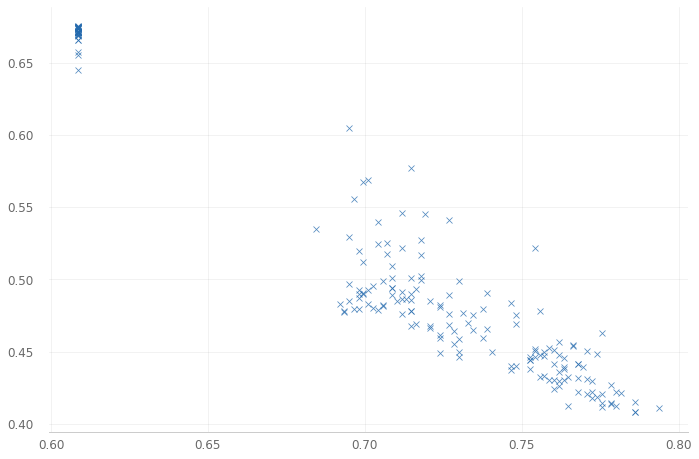

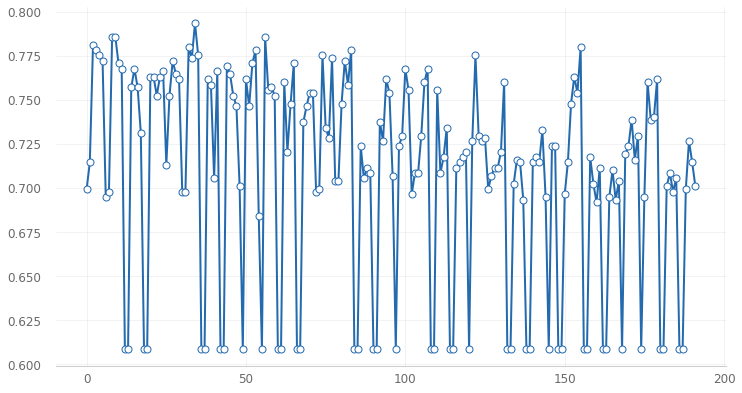

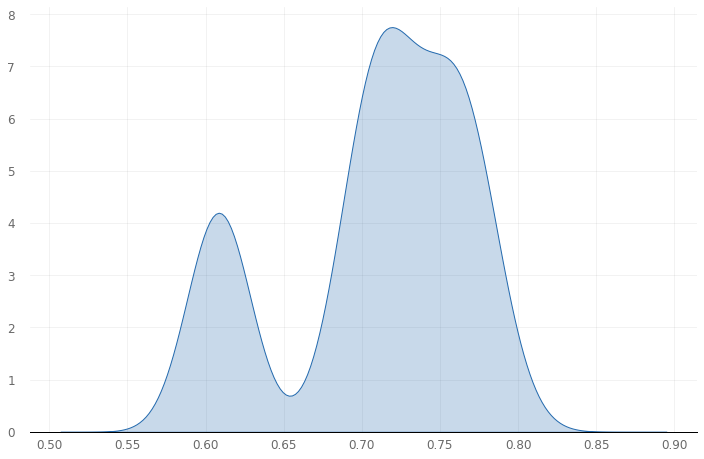

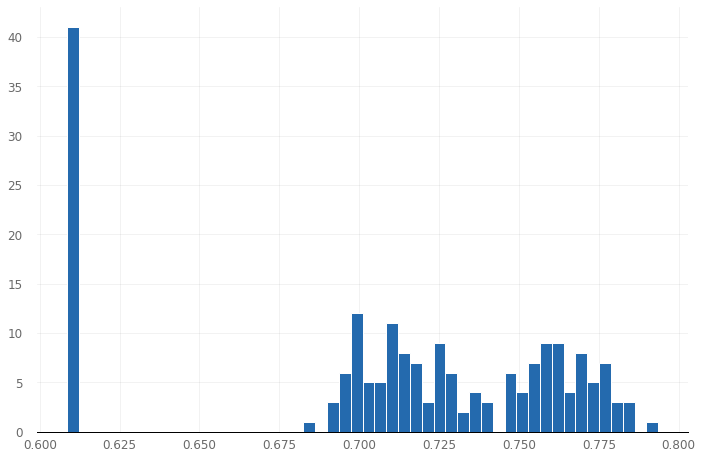

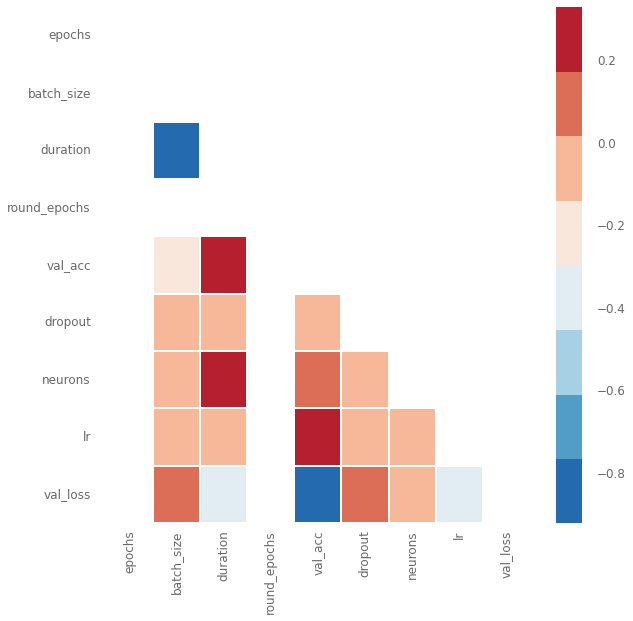

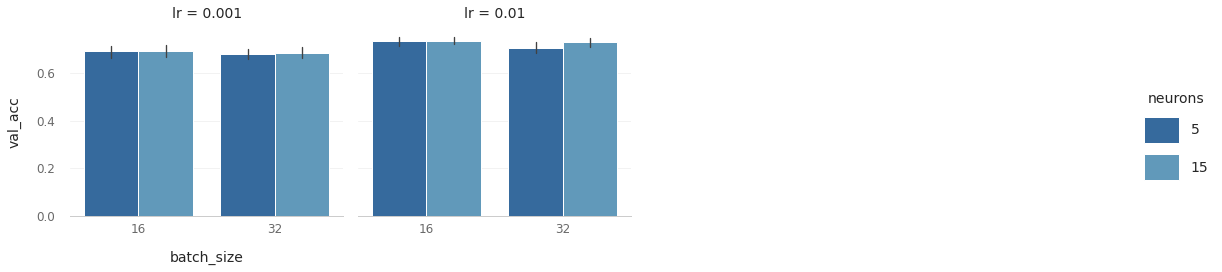

In [73]:
# a regression plot for two dimensions 
analyze_object.plot_regs('val_acc', 'val_loss')

# line plot
analyze_object.plot_line('val_acc')

# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_acc')

# a simple histogram
analyze_object.plot_hist('val_acc', bins=50)

# heatmap correlation
analyze_object.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

# a four dimensional bar grid
analyze_object.plot_bars('batch_size', 'val_acc', 'neurons', 'lr')

In [79]:
ta.Deploy(scan_object=t, model_name='cmapss_model', metric='val_acc');

Deploy package cmapss_model have been saved.


In [81]:
cmapss_best_model = ta.Restore('cmapss_model.zip')

In [82]:
# make predictions with the model
cmapss_best_model.model.predict(x_train[:, :, np.newaxis])

array([[0.28940165],
       [0.43167233],
       [0.57318187],
       ...,
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)